In [53]:
require(tidyr)
require(ggplot2)

In [54]:
cubicDF = read.csv("../Results/cubic_model.csv")
flschDF = read.csv("../Results/full_scholfield_model.csv")
nhschDF = read.csv("../Results/noh_scholfield_model.csv")
nlschDF = read.csv("../Results/nol_scholfield_model.csv")
arrhnDF = read.csv("../Results//arrhenius_model.csv")

aicdf = data.frame("NewID" = cubicDF$NewID,
                  "cubic" = cubicDF$nlaic,
                  "flsch" = flschDF$nlaic,
                  "nhsch" = nhschDF$nlaic,
                  "nlsch" = nlschDF$nlaic,
                  "arrhn" = arrhnDF$nlaic)

In [124]:
delta = function(row, model){
    abs(min(row, na.rm = TRUE) - row[model])
}

weight = function(row, model_delta, comparing){
    if (is.na(row[model_delta])){
        0
    } else{
        exp(-.5*row[model_delta])/sum(exp(-.5*row[comparing]), na.rm = TRUE)
    }
}

compare = function(models){

    DFaic    = paste0(models, "DF$nlaic")
    DFdelta  = paste0(models, "_delta")
    DFweight = paste0(models, "_weight")
    DFpass   = paste0(models, "_pass")


    aicDF = data.frame("NewID" = eval(parse(text = (paste0(models[1], "DF$NewID")))))

    for (i in 1:length(models)){
        aicDF = cbind(aicDF, eval(parse(text = DFaic[i])))
    }
    
    colnames(aicDF) = c("NewID", models)
    
    for (i in 1:length(models)){
        aicDF[DFdelta[i]] = apply(aicDF, 1, delta, model = mdls[i])
    }

    for (i in 1:length(models)){
        aicDF[DFweight[i]] =  apply(aicDF, 1, weight, model_delta = DFdelta[i],
                               comparing = DFdelta)
    }
    
    for (i in 1:length(models)){
        aicDF[DFpass[i]] =  eval(parse(text = (paste0("aicDF$", DFdelta[i])))) <= 2
    }
   
    cat("Based off of delta when < 2 from minimum aic means models are comparable\n\n")
    
    for (i in 1: length(models)){
        passed = sum(eval(parse(text = (paste0("aicDF$", DFpass[i])))), na.rm = TRUE)
        
        cat(paste0(models[i], ": ", passed, " (", round((passed/nrow(aicDF))*100, 2),
                   "%) curves best or comparable to best\n"))
    } 
    
    
    pltDF = data.frame(NewID  = aicDF$NewID, model = mdls[1],
                   aic    = eval(parse(text = DFaic[1])),
                   delta  = eval(parse(text = paste0("aicDF$",DFdelta[1]))),
                   weight = eval(parse(text = paste0("aicDF$",DFweight[1]))))

    for(i in 2:length(mdls)){
        pltDF = rbind.data.frame(pltDF, data.frame(NewID  = aicDF$NewID, model = models[i],
                                                   aic    = eval(parse(text = DFaic[1])),
                                                   delta  = eval(parse(text = paste0("aicDF$",DFdelta[i]))),
                                                   weight = eval(parse(text = paste0("aicDF$",DFweight[i])))))
    }
    
    plt = ggplot(data = pltDF, aes(y = weight, x = model))
    plt = plt + geom_boxplot(outlier.shape=NA)
    plt = plt + geom_jitter(position=position_jitter(width=.3, height=0), alpha = 0.3, cex = .5)
    plt = plt + stat_summary(fun.y=mean, geom="point", shape=18, size=5, show.legend = FALSE)
    plt = plt + theme_classic()
    print(plt)
    
    
    fit <- aov(weight ~ model, data = pltDF)
    
    cat("\n\n\nNow looking at weighted aic\n\n")
    print(TukeyHSD(fit))
    
    return(aicDF)
}

Based off of delta when < 2 from minimum aic means models are comparable

cubic: 990 (62.58%) curves best or comparable to best
flsch: 454 (28.7%) curves best or comparable to best
nhsch: 471 (29.77%) curves best or comparable to best
nlsch: 370 (23.39%) curves best or comparable to best
arrhn: 19 (1.2%) curves best or comparable to best



Now looking at weighted aic

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = weight ~ model, data = pltDF)

$model
                   diff         lwr          upr     p adj
flsch-cubic -0.21306716 -0.23962565 -0.186508681 0.0000000
nhsch-cubic -0.35464330 -0.38120179 -0.328084821 0.0000000
nlsch-cubic -0.38799611 -0.41455459 -0.361437629 0.0000000
arrhn-cubic -0.44582578 -0.47238426 -0.419267297 0.0000000
nhsch-flsch -0.14157614 -0.16813462 -0.115017658 0.0000000
nlsch-flsch -0.17492895 -0.20148743 -0.148370465 0.0000000
arrhn-flsch -0.23275862 -0.25931710 -0.206200134 0.0000000
nlsch-nhsch -0.03335281

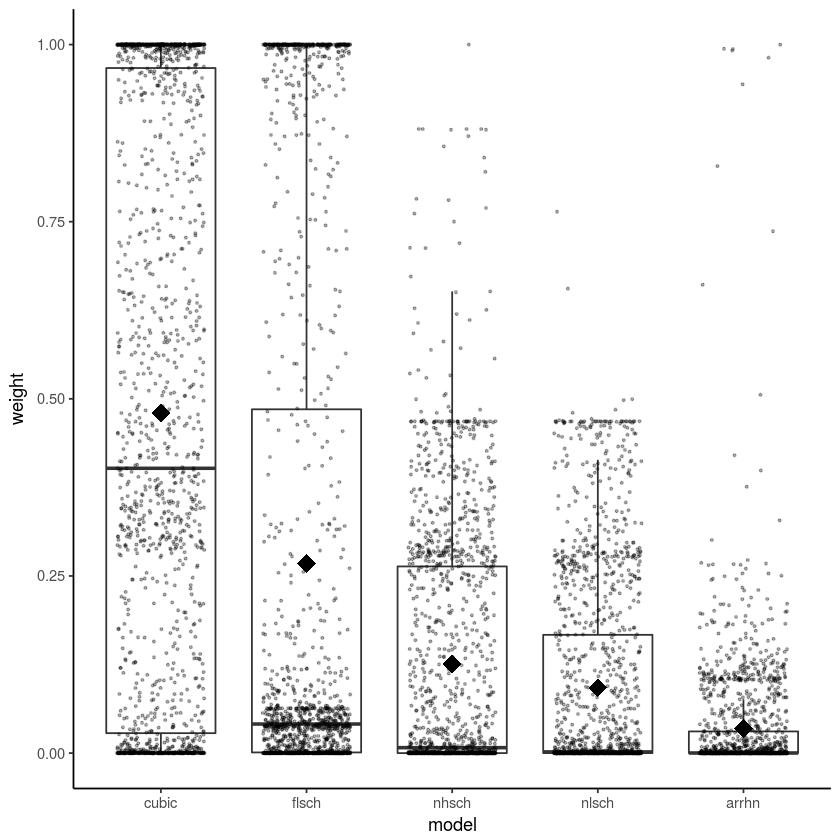

In [125]:
mdls = c("cubic", "flsch", "nhsch", "nlsch", "arrhn")
#mdls = c("flsch", "nhsch", "nlsch", "arrhn")

aicDF = compare(mdls)